In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Common imports
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gp
from sklearn.cross_validation import train_test_split
from sklearn import svm

In [3]:
# Make plots prettyful
pl.style.use('fivethirtynine')

In [4]:
# Pull in data
demographics = pd.read_excel('../data/DemoData.xlsx')
demographics['tract'] = demographics.ID.astype(str).str.zfill(9)

shp = gp.GeoDataFrame.from_file('../data/merged.json')

shp = shp.merge(demographics, on='tract')

shp.rename(columns={
#    'Destination?': 'is_dest',
    'Origin?': 'is_orig',
    'Total Population': 'pop',
    '18 to 24 yrs': '_18_to_24',
    '65 and Above': 'above_65',
    'Median Age': 'age',
    'Non-white': 'nonwhite',
    'English less than "very well"': 'nonenglish',
    'Annaul Individual Income below 10000': 'income_below_10000',
    'Annaul Individual Income below 15000': 'income_below_15000',
    'Median Income': 'income',
    'Below 100 percent of the poverty level': 'below_pov',
    '100 to 149 percent of the poverty level': '_100_149_pov',
    'At or above 150 percent of the poverty level': 'above_150_pov',
    'Citizenship status': 'noncitizen',
    'Place of Birth': 'foreignborn'
}, inplace=True)

lehd = pd.read_csv('../data/merged.csv', dtype={'tract': str})

lehd = lehd.drop([u'Unnamed: 0', u'Both', u'Destination?', u'DollarVanLine', u'Origin?',
       u'average_commute_time', u'average_walk_distance', u'geometry',
       u'number_of_commuters',  u'w_county_tract', u'h_county_tract'], 1)

shp = shp.merge(lehd, on='tract')

routes = pd.read_csv('../data/allD2.csv', dtype={'BoroCT2010': str})

routes['BoroCode'] = routes.BoroCT2010.str[0]

routes['county_code'] = ""
routes['county_code'][routes['BoroCode'] == '1'] = '061' # Manhattan
routes['county_code'][routes['BoroCode'] == '2'] = '005' # Bronx
routes['county_code'][routes['BoroCode'] == '3'] = '047' # Brooklyn
routes['county_code'][routes['BoroCode'] == '4'] = '081' # Queens
routes['county_code'][routes['BoroCode'] == '5'] = '085' # Staten Island

routes['tract'] = routes['county_code'] + routes['BoroCT2010'].str[1:]

routes['is_dest'] = 0
routes['is_dest'][routes['BUFF_DIST'] == .5] = 1

shp = shp.merge(routes[['tract', 'is_dest']], on='tract')

# Standardize Value Range
for c in [
        u'average_commute_time', u'average_walk_distance',
        u'number_of_commuters',u'pop',
                       u'_18_to_24',                    u'above_65',
                         u'age',             u'nonwhite',
                  u'nonenglish',    u'income_below_10000',
          u'income_below_15000',                u'income',
                   u'below_pov',           u'_100_149_pov',
               u'above_150_pov',            u'noncitizen',
                 u'foreignborn',
    u'wac_total_jobs',
              u'wac_jobs_lt_29',        u'wac_jobs_30_54',
              u'wac_jobs_gt_55',      u'wac_minc_lt_1250',
          u'wac_minc_1251_3333',      u'wac_minc_gt_3333',
              u'rac_total_jobs',        u'rac_jobs_lt_29',
              u'rac_jobs_30_54',        u'rac_jobs_gt_55',
            u'rac_minc_lt_1250',    u'rac_minc_1251_3333',
            u'rac_minc_gt_3333'
]:
    shp[c] = ((shp[c] - shp[c].mean())/shp[c].std())
    
shp = shp.dropna()

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

In [5]:
data = shp[[
    'average_commute_time', 
    'average_walk_distance',
    'number_of_commuters',
    'pop',
    '_18_to_24',
    'above_65',
    'age',
    'nonwhite',
    'nonenglish',
    'income_below_10000',
    'income_below_15000',
    'income',
    'below_pov',
    '_100_149_pov',
    'above_150_pov',
    'noncitizen',
    'foreignborn',
    'wac_total_jobs',
    'wac_jobs_lt_29',        
    'wac_jobs_30_54',
    'wac_jobs_gt_55', 
    'wac_minc_lt_1250',
    'wac_minc_1251_3333',      
    'wac_minc_gt_3333',
    'rac_total_jobs',
    'rac_jobs_lt_29',
    'rac_jobs_30_54',  
    'rac_jobs_gt_55',
    'rac_minc_lt_1250',    
    'rac_minc_1251_3333',
    'rac_minc_gt_3333'
]].values

is_orig = shp['is_orig'].values
is_dest = shp['is_dest'].values
is_both = shp['Both'].values

In [6]:
np.random.seed(1)

target = is_orig

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=.33)

svc = svm.SVC(
    C=1, kernel='poly', degree=5, gamma='auto', coef0=.4, shrinking=False, 
    probability=False, tol=0.0001, cache_size=200, class_weight={1: 6}, verbose=False, 
    max_iter=-1, decision_function_shape=None
)
svc.fit(train_data, train_target)

pred = svc.predict(train_data)

print "Test Set"
print "% origin misclassified =", 1.*(train_target[train_target == 1] != pred[train_target == 1]).sum()/train_target[train_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(train_target[train_target == 0] != pred[train_target == 0]).sum()/train_target[train_target == 0].shape[0]

pred = svc.predict(test_data)

print "Test Set"
print "% origin misclassified =", 1.*(test_target[test_target == 1] != pred[test_target == 1]).sum()/test_target[test_target == 1].shape[0]
print "% nonorigin misclassified =", 1.*(test_target[test_target == 0] != pred[test_target == 0]).sum()/test_target[test_target == 0].shape[0]

Test Set
% origin misclassified = 0.0659722222222
% nonorigin misclassified = 0.193091231178
Test Set
% origin misclassified = 0.20253164557
% nonorigin misclassified = 0.238888888889


In [7]:
shp['is_orig_pred'] = svc.predict(data)

In [8]:
np.random.seed(1)

target = is_dest

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=.33)

svc = svm.SVC(
    C=1, kernel='poly', degree=6, gamma='auto', coef0=.4, shrinking=False, 
    probability=False, tol=0.0001, cache_size=200, class_weight={1: 3}, verbose=False, 
    max_iter=-1, decision_function_shape=None
)
svc.fit(train_data, train_target)

pred = svc.predict(train_data)

print "Test Set"
print "% dest misclassified =", 1.*(train_target[train_target == 1] != pred[train_target == 1]).sum()/train_target[train_target == 1].shape[0]
print "% nondest misclassified =", 1.*(train_target[train_target == 0] != pred[train_target == 0]).sum()/train_target[train_target == 0].shape[0]

pred = svc.predict(test_data)

print "Test Set"
print "% dest misclassified =", 1.*(test_target[test_target == 1] != pred[test_target == 1]).sum()/test_target[test_target == 1].shape[0]
print "% nondest misclassified =", 1.*(test_target[test_target == 0] != pred[test_target == 0]).sum()/test_target[test_target == 0].shape[0]

Test Set
% dest misclassified = 0.44
% nondest misclassified = 0.0
Test Set
% dest misclassified = 0.928571428571
% nondest misclassified = 0.00438596491228


In [9]:
shp['is_dest_pred'] = svc.predict(data)

In [46]:
shp2 = gp.GeoDataFrame.from_file('../data/merged.json')
#shp4 = shp2.merge(routes[['tract', 'is_dest']])
#shp2['is_dest'] = routes['is_dest']
#shp4 = shp2.merge(routes[['tract', 'is_dest']], on='tract')
shp3 = shp2.merge(routes, on='tract').merge(shp[['tract', 'is_orig_pred', 'is_dest_pred']], how='left', on='tract')

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


In [47]:
shp3['orig_plot'] = "None"
shp3['orig_plot'][shp3['is_orig_pred'] == 1] = "Predicted"
shp3['orig_plot'][shp3['Origin?'] == 1] = "Actual"

shp3['dest_plot'] = "None"
shp3['dest_plot'][shp3['is_dest_pred'] == 1] = "Predicted"
shp3['dest_plot'][shp3['is_dest'] == 1] = "Actual"

c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: Setti

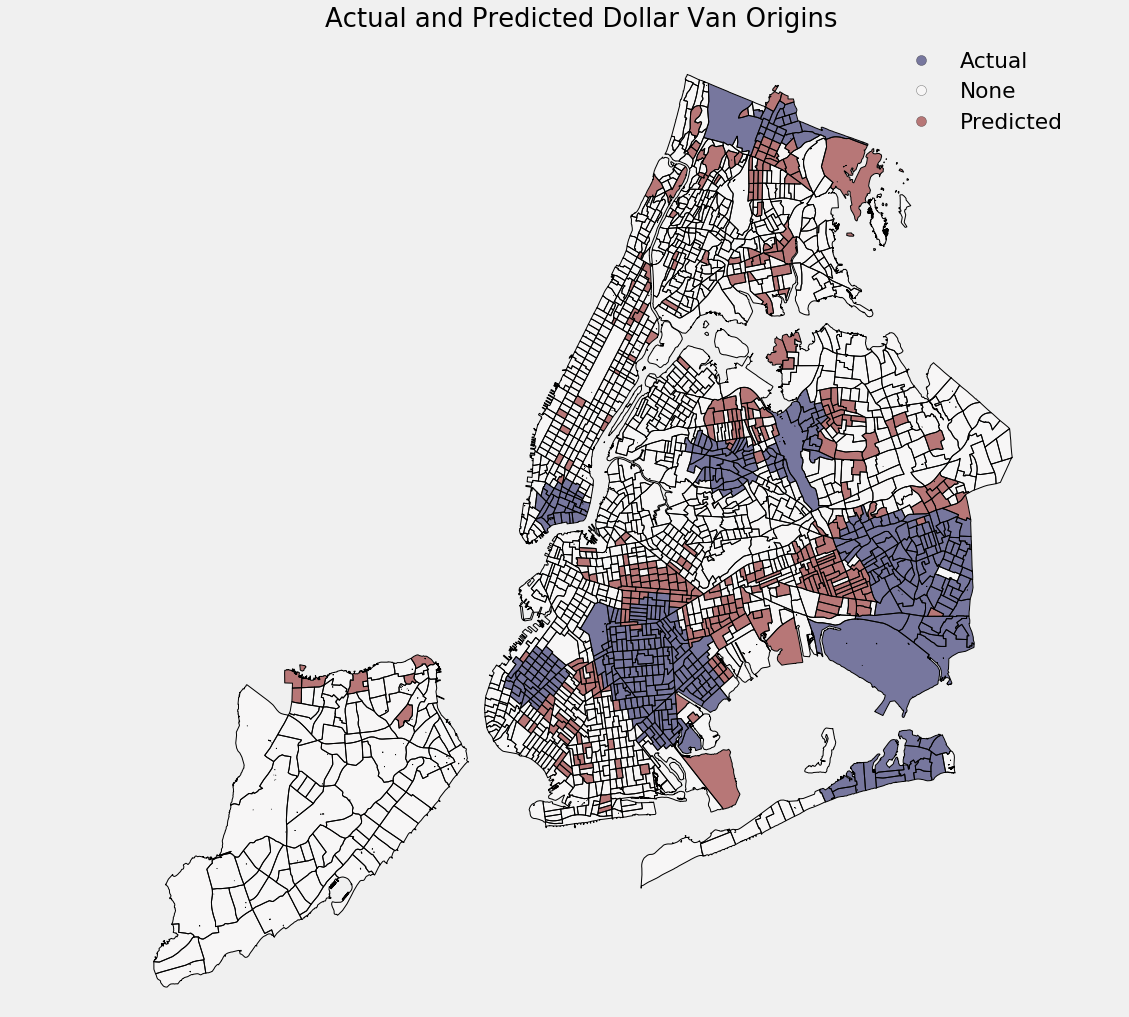

In [52]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp3.plot(axes=ax, column='orig_plot', legend=True, categorical=True, colormap='seismic') #prism, magma, winter
ax.set_title('Actual and Predicted Dollar Van Origins')

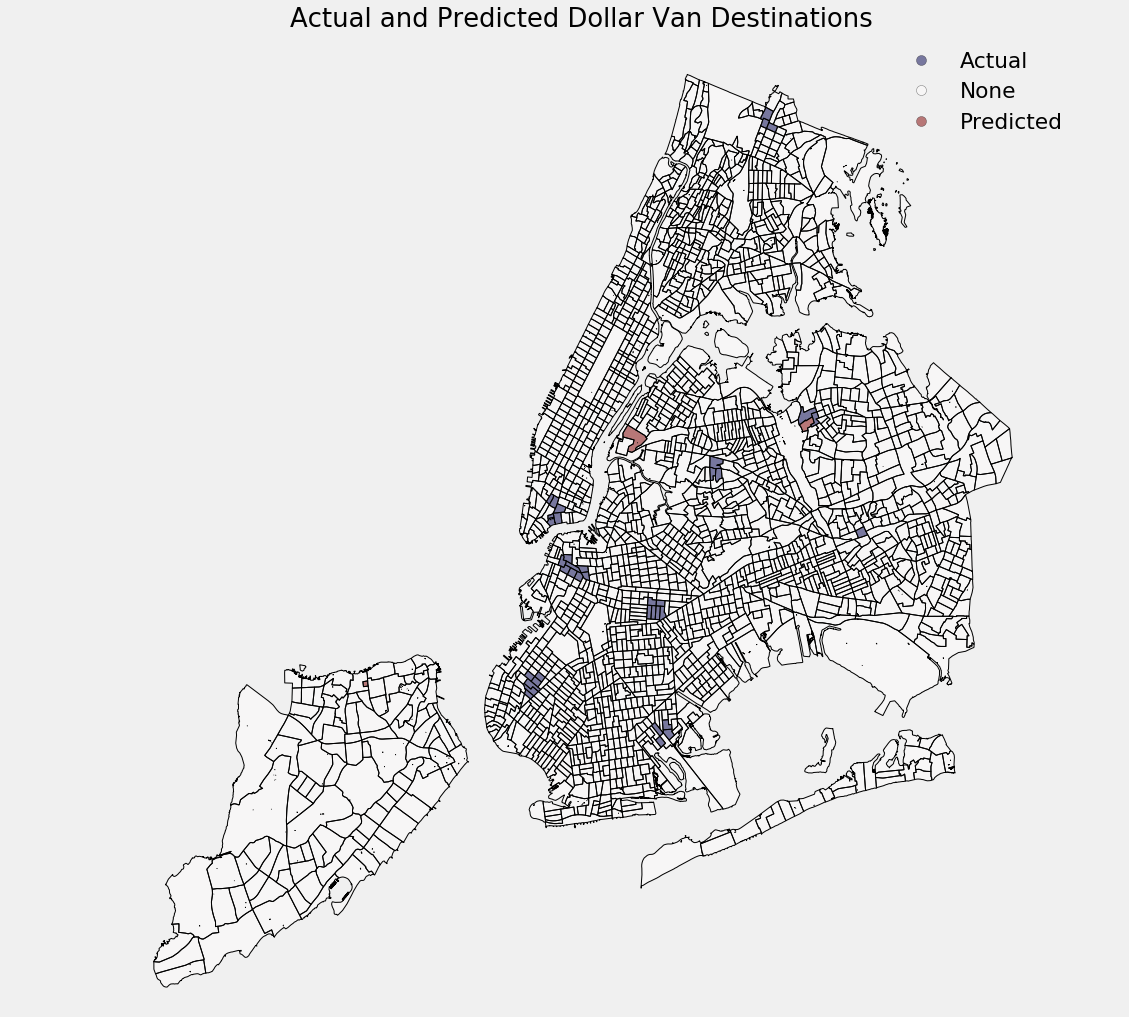

In [51]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp3.plot(axes=ax, column='dest_plot', legend=True, categorical=True, colormap='seismic') #prism, magma, winter
ax.set_title('Actual and Predicted Dollar Van Destinations')